# Turbulent Mixing Layer Example
This is an example of using the Turbulent Mixing Layer flow
A two-dimensional flow is initialized with flow on the bottom and simulated. Afterwards, the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

In [2]:
nmax     = 2000
nconsole = 5000
nreport  = 10
epsilon  = 0.0001 # convergence condition: .01 % relative change

In [3]:
def plot_flow(lattice, flow, simulation, i):
    u_x = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).cpu().numpy()[0][:,:,0].transpose()
    plt.imshow(u_x, cmap=mpl.colormaps['RdBu'])
    plt.title("Re: " + str(Re) + ", " + str(i*nconsole) + " steps, " + str(flow.units.convert_time_to_pu(i*nconsole)) + " seconds")
    plt.show()

def run_n_plot(Re):
    lattice = lt.Lattice(lt.D3Q27, device = torch.device("cuda"), dtype=torch.float64, use_native=False)
    flow = lt.TurbulentMixing3D(resolution=64, reynolds_number=Re, mach_number=0.3, lattice=lattice)
    collision = lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
    streaming = lt.StandardStreaming(lattice)
    simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

    Energy = lt.IncompressibleKineticEnergy(lattice, flow)
    energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
    simulation.reporters.append(energy_reporter_internal)
    simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
    simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport, filename_base="./data/turbulence_3D_Re" + "{:e}".format(Re) + "/out"))

    simulation.initialize_f_neq()
    energy_new = 0
    mlups = 0
    i_plot = 10
    iterations = int(nmax//nconsole)
    for i in range(iterations):
        energy_old = energy_new
        energy_new = Energy(simulation.f).mean()
        if i%i_plot == 0:
            plot_flow(lattice, flow, simulation, i)
        mlups += simulation.step(nconsole)
        if abs((energy_new - energy_old)/energy_new) < epsilon:
            print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
            break
        if not energy_new == energy_new:
            print("CRASHED! Received nan values")
            break
    print("avg MLUPS: ", mlups/iterations)
    return lattice, flow, simulation

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy


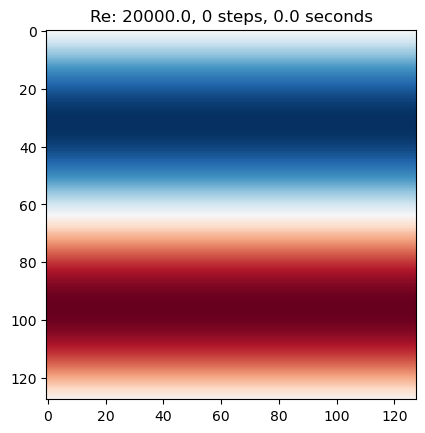

0 0.0 0.24999999999999986


/home/philipp/lettuce/lettuce/simulation.py:122: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorCompare.cpp:493.)
  self.f = torch.where(self.collision.no_collision_mask, self.f, self.collision(self.f))


1000 0.45105489780439517 0.24955511261105265
2000 0.9021097956087903 0.24911103863474549
3000 1.3531646934131856 0.24866775407328492
4000 1.8042195912175807 0.24822525831708037
5000 2.255274489021976 0.2477835499668535
6000 2.706329386826371 0.24734262762151277
7000 3.157384284630766 0.2469024898823932
8000 3.6084391824351614 0.2464631353533149
9000 4.059494080239556 0.24602456264058067
10000 4.510548978043952 0.2455867703529775


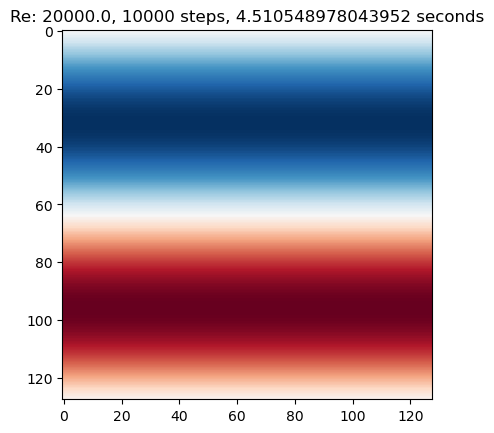

11000 4.961603875848347 0.24514975710176357
12000 5.412658773652742 0.24471352150067038
13000 5.863713671457138 0.24427806216589584
14000 6.314768569261532 0.24384337771609765
15000 6.765823467065927 0.24340946677240238
16000 7.216878364870323 0.24297632795837762
17000 7.667933262674718 0.24254395990004476
18000 8.118988160479113 0.24211236122587368
19000 8.570043058283508 0.2416815305667708
20000 9.021097956087903 0.24125146655607607


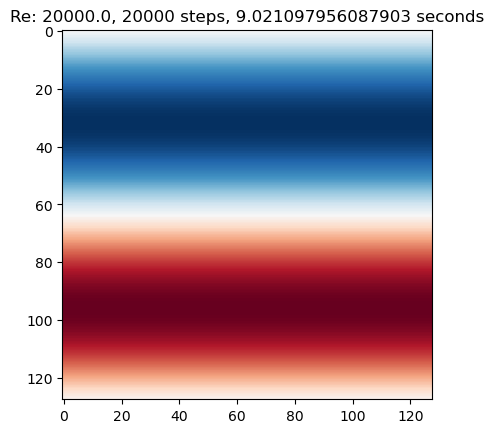

21000 9.472152853892299 0.24082216782956742
22000 9.923207751696694 0.24039363302544933
23000 10.37426264950109 0.23996586078434642


KeyboardInterrupt: 

In [4]:
for Re in [2e4]:
    lat, fl, sim = run_n_plot(Re)
    plot_flow(lat, fl, sim, nmax)
    energy = np.array(sim.reporters[0].out)
    plt.plot(energy[:,1],energy[:,2])
    plt.title('Kinetic energy')
    plt.xlabel('Time')
    plt.ylabel('Energy in physical units')
    plt.show()